# Rauschen

## initial imports

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks,find_peaks_cwt
import scipy.signal as sig
import scipy.special as sp
import scienceplots
plt.figure()
plt.style.use('science')
plt.rcParams['errorbar.capsize'] = 5
plt.rcParams['text.usetex'] = False # disable latex
plt.rcParams['figure.dpi'] = 150
import os
import fp

<Figure size 640x480 with 0 Axes>

In [2]:
#aliases
from uncertainties import ufloat as uf
from uncertainties.unumpy import uarray as ua
from uncertainties.unumpy import nominal_values as nv
from uncertainties.unumpy import std_devs as sd

In [3]:
outdir = f'plots/rauschen/'
datadir = f'data/rauschen/'
os.makedirs(outdir, exist_ok=True)

## Part 1 Johnson - Nyquist Noise

In [4]:
dat1 = pd.read_csv(datadir+'Rauschen - 1 - Johnson R,df.tsv',delimiter='\t',decimal=',')
dat1

,Messung,g2,f1 Hz,f2 Hz,df kHz,R Ohm,V mV,uV,comment
0,1,5000,300,330,105,1,8.3,0.3,hintergrund 1
1,2,5000,100,1000,1000,1,59.0,1.5,hintergrund 2
2,3,5000,30,3300,3632,1,205.0,1.5,hintergrund 3
3,4,5000,30,10000,11075,1,602.0,3.0,hintergrund 4
4,5,500,10,100000,111061,1,63.2,0.1,hintergrund 5
5,6,5000,300,330,105,100,8.5,0.2,widerstand 1.1
6,10,5000,100,1000,1000,100,60.0,1.0,widerstand 1.2
7,14,5000,30,3300,3632,100,211.0,1.0,widerstand 1.3
8,18,1000,30,10000,11075,100,26.6,0.1,widerstand 1.4
9,22,1000,10,100000,111061,100,255.0,0.3,widerstand 1.5


In [5]:
def nyquist(R,T,df, k):
    return 4*k*T*R*df
def kb(R,T,df,v2):
    return v2/(4*R*T*df)
def dv2n(v, g1, g2):
    return v*1e-3 * 10 / (g1*g2)**2
def linfit(x, a ,b):
    return a*x + b

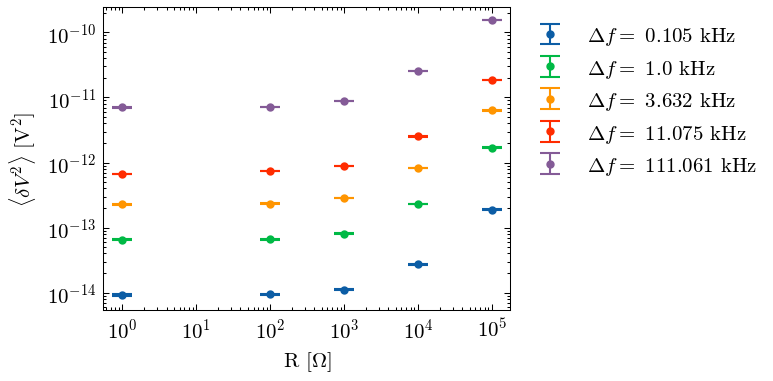

In [6]:
# over R
plt.figure()
for i in range(5):
    dat = dat1[i::5]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    df = dat['df kHz'].mean()*1e-3
    plt.errorbar(dat['R Ohm'],nv(y),yerr=sd(y),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [$\Omega$]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')

plt.savefig(outdir+'1-johnson_rauschen_R.pdf',bbox_inches='tight')

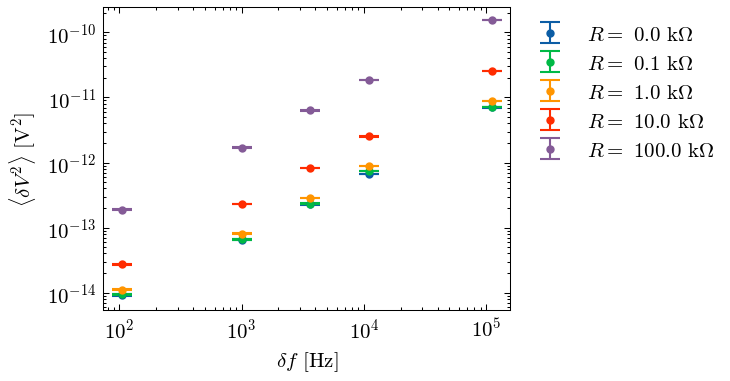

In [7]:
# over df unbereinigt
plt.figure()
# dat = dat1[0:5]
# y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(0,5):
    dat = dat1[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'1-johnson_rauschen_df_raw.pdf',bbox_inches='tight')

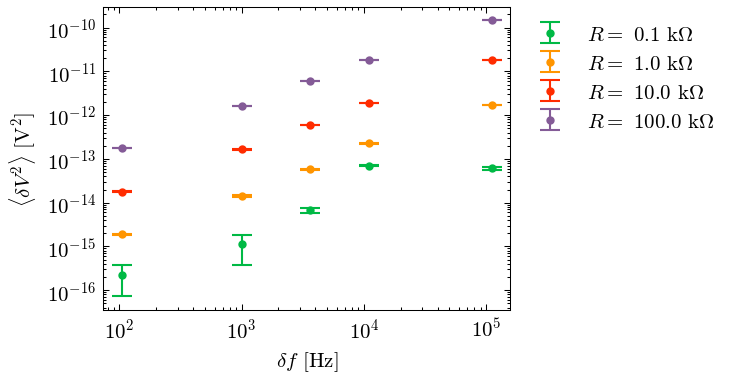

In [8]:
# over df
plt.figure()
dat = dat1[0:5]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
# k_b = []
for i in range(1,5):
    dat = dat1[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y/1.5),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$',color=f'C{i}')
    # def nqfit(df, k):
    #     return nyquist(r*1e3, 294.15, df, k)
    # popt, pcov  = curve_fit(linfit, dat['df kHz'], nv(y)-nv(y0), sigma=sd(y))
    # k_b.append(uf(popt[0],np.sqrt(pcov[0,0])))

    # plt.plot(dat['df kHz'],nv(nqfit(dat['df kHz'], con.k)),color=f'C{i}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'1-johnson_rauschen_df.pdf',bbox_inches='tight')

[9.077153588132475e-24+/-6.584422053852362e-24,
 1.4024724094934217e-23+/-8.0961738166551325e-25,
 1.4236725970553612e-23+/-2.0353299371307948e-26,
 1.1789620181390845e-23+/-5.612139014173158e-25]

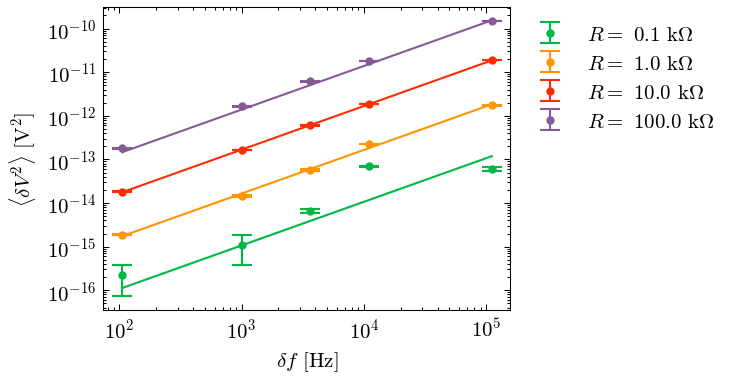

In [9]:
# over df
plt.figure()
dat = dat1[0:5]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
k_b = []
for i in range(1,5):
    dat = dat1[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y/1.5),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$',color=f'C{i}')
    def nqfit(df, k):
        return nyquist(r*1e3, 294.15, df, k)
    popt, pcov  = curve_fit(nqfit, dat['df kHz'], nv(y)-nv(y0), sigma=sd(y))
    k_b.append(uf(popt[0],np.sqrt(pcov[0,0])))

    plt.plot(dat['df kHz'],nv(nqfit(dat['df kHz'], *popt)),color=f'C{i}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'1-johnson_rauschen_df_fit.pdf',bbox_inches='tight')
k_b

In [10]:
con.k

1.380649e-23

In [11]:
print(r"\begin{tabular}{c|c}")
print(r"$R$ [k$\Omega$] & $k_B$ [J/K] \\")

\begin{tabular}{c|c}
$R$ [k$\Omega$] & $k_B$ [J/K] \\


## 2 Shot Noise

In [12]:
dat2 = pd.read_csv(datadir+'Rauschen - 2 - Shot.tsv',delimiter='\t',decimal=',')
dat2

,Messung,g2,f1 Hz,f2 Hz,df Hz,R kOhm,Vdc V,uVdc,Vn mV,uVn,comment
0,21,2000,1000,10000,9997,10,0.00029,0.0005,11.35,0.05,hintergrund 1
1,1,2000,1000,10000,9997,10,-0.42420,0.0002,68.50,0.20,NaN
2,2,2000,1000,10000,9997,10,-0.85220,0.0002,126.00,0.50,NaN
3,3,2000,1000,10000,9997,10,-1.31000,0.0002,187.00,2.00,NaN
4,4,2000,1000,10000,9997,10,-1.83400,0.0002,265.00,5.00,NaN
5,5,2000,1000,10000,9997,10,-2.23000,0.0005,315.00,4.00,NaN
6,6,2000,1000,10000,9997,10,-2.67000,0.0005,371.00,2.00,NaN
7,7,2000,1000,10000,9997,10,-3.12000,0.0005,437.00,4.00,NaN
8,8,2000,1000,10000,9997,10,-3.56000,0.0005,498.00,4.00,NaN
9,9,2000,1000,10000,9997,10,-4.01000,0.0005,555.00,8.00,NaN


In [13]:
def shot(i_dc,df):
    return 2*con.e*i_dc*df
def e_0 (i_dc,df, di2):
    return di2/(2*i_dc*df)
def i_dc(v_dc,rf):
    return -v_dc/rf
def di2s(v, g1, g2, rf):
    return v*1e-3 * 10 / (g1*g2*rf)**2

[1.8759918868696377e-19+/-3.9322127613866956e-21,
 1.8383934270511287e-19+/-3.7732303603843444e-21]

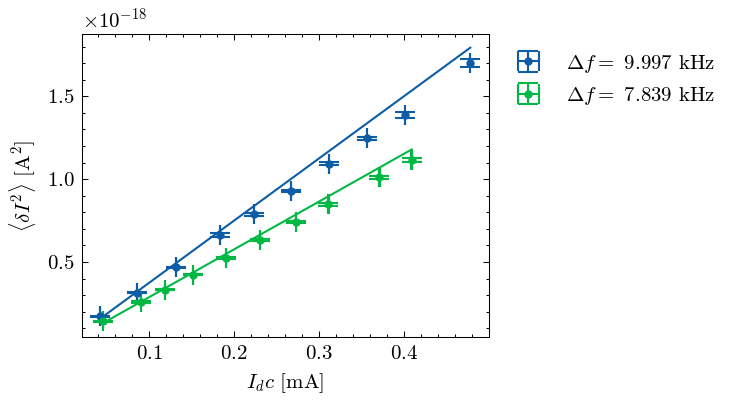

In [14]:
# over df Raumtemp raw
plt.figure()
e_0s= []
for i in range(0,2):
    dat = dat2[11*i+1:11*(i+1)]
    v_dc = ua(dat['Vdc V'],dat[f'uVdc'])
    v_n = ua(dat['Vn mV'],dat[f'uVn'])
    r = dat['R kOhm'].mean()
    x = i_dc(v_dc, r*1e3)*1e3
    y = di2s(v_n, 100, dat['g2'], r*1e3)
    df = dat['df Hz'].mean()*1e-3
    plt.errorbar(nv(x),nv(y),yerr=sd(y),xerr=sd(x),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz',color=f'C{i}')
    def shotfit(i_dc, e):
        return 2*e*i_dc*df
    popt, pcov  = curve_fit(shotfit, nv(x), nv(y), sigma=sd(y))
    plt.plot(nv(x),nv(shotfit(x, *popt)),color=f'C{i}')
    e_0s.append(uf(popt[0],np.sqrt(pcov[0,0])))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$I_dc$ [mA]')
plt.ylabel(r'$\langle\delta I^2\rangle$ [A$^2$]')
plt.savefig(outdir+'2-schrot_rauschen_raw.pdf',bbox_inches='tight')
e_0s

## 3 Absolute Zero

In [15]:
dat3 = pd.read_csv(datadir+'Rauschen - 3 - Johnson T.tsv',delimiter='\t',decimal=',')
dat3[::5]

,Messung,g2,f1 Hz,f2 Hz,df kHz,R Ohm,uR,T Celsius,dT,V mV,uV,comment
0,1,5000,300,330,105,11.0,1.2,21,1,7.7,0.1,R_A (Hintergrund)
5,2,5000,300,330,105,9970.0,40.0,21,1,23.8,0.1,R_B
10,3,5000,300,330,105,100500.0,1000.0,21,1,168.0,2.0,R_C
15,16,500,300,330,105,11.8,2.0,-195,1,21.0,0.5,R_A (Hintergrund)
20,17,500,300,330,105,9960.0,10.0,-195,1,35.1,0.1,R_B
25,18,500,300,330,105,101000.0,1000.0,-195,1,93.2,0.2,R_C


In [16]:
temp = ua(dat3["T Celsius"][::15]+273.15,dat3["dT"][::15])
temp

array([294.15+/-1.0, 78.14999999999998+/-1.0], dtype=object)

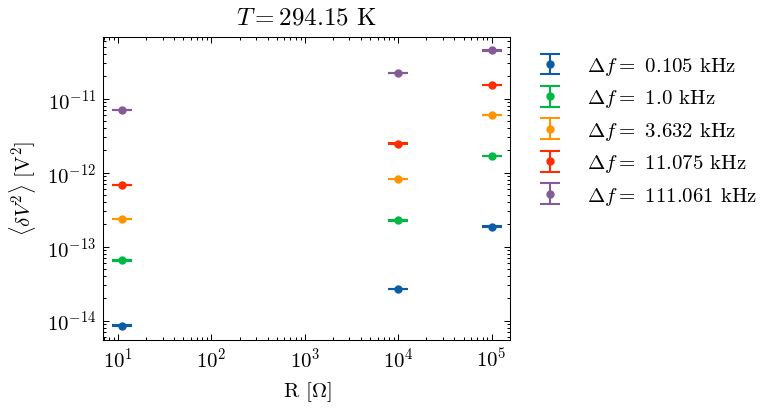

In [17]:
# over R raumtemperatur
plt.figure()
plt.title(f'$T ={round(dat3["T Celsius"][0]+273.15,2)}$ K')

for i in range(5):
    dat = dat3[i:15:5]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    df = dat['df kHz'].mean()*1e-3
    plt.errorbar(dat['R Ohm'],nv(y),yerr=sd(y),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [$\Omega$]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df-raumtemperatur.pdf',bbox_inches='tight')


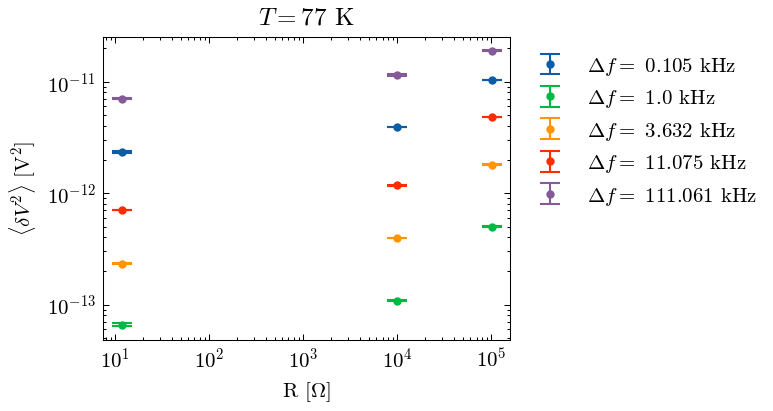

In [18]:
# over R flussigstickstoff
plt.figure()
plt.title(f'$T =77$ K')

for i in range(5):
    dat = dat3[i+15::5]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    df = dat['df kHz'].mean()*1e-3
    plt.errorbar(dat['R Ohm'],nv(y),yerr=sd(y),fmt='.',label=f'$\Delta f=$ {round(df,3)} kHz')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R [$\Omega$]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_R-77K.pdf',bbox_inches='tight')


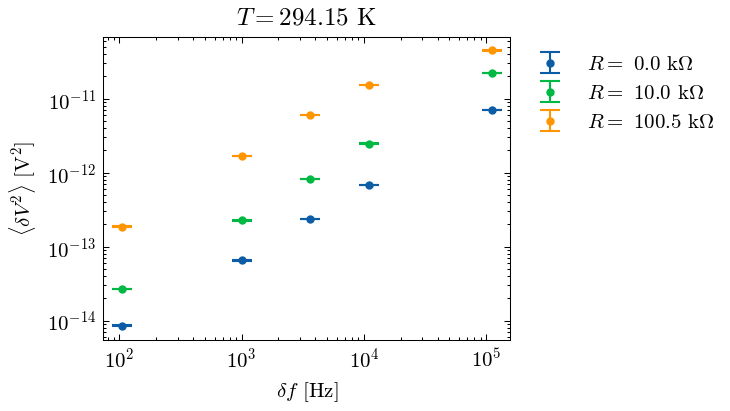

In [19]:
# over df Raumtemp raw
plt.figure()
plt.title(f'$T ={round(dat3["T Celsius"][0]+273.15,2)}$ K')

dat = dat3[0:5]
# y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(0,3):
    dat = dat3[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df_raw-raumtemperatur.pdf',bbox_inches='tight')

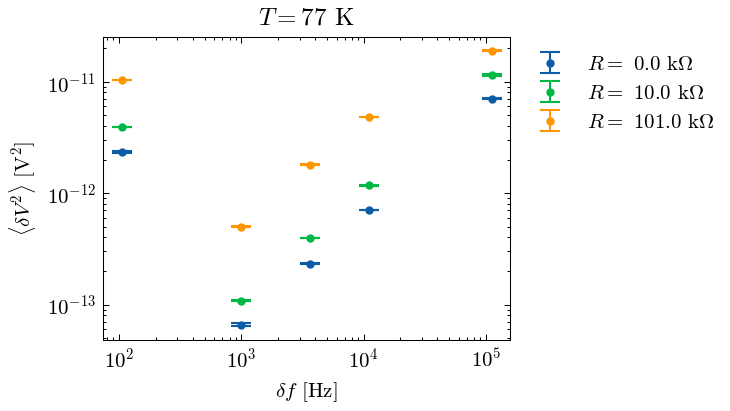

In [20]:
# over df Fluessigstickstoff
plt.figure()
plt.title(f'$T =77$ K')
dat = dat3[15:20]
# y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(0,3):
    dat = dat3[15+5*i:15+5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df_raw-77K.pdf',bbox_inches='tight')

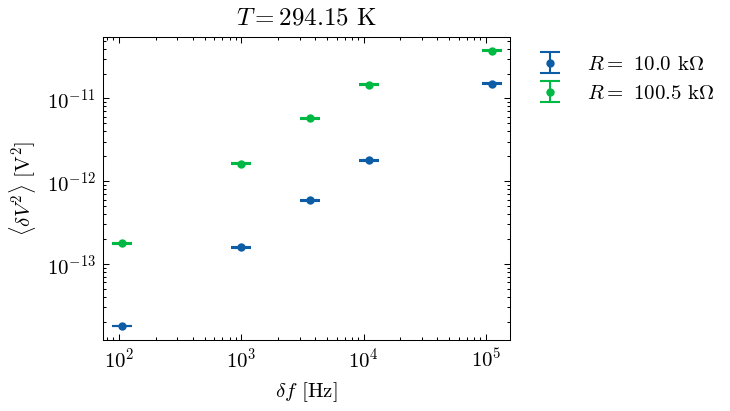

In [21]:
# over df Raumtemp
plt.figure()
plt.title(f'$T ={round(dat3["T Celsius"][0]+273.15,2)}$ K')

dat = dat3[0:5]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(1,3):
    dat = dat3[5*i:5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df-raumtemperatur.pdf',bbox_inches='tight')

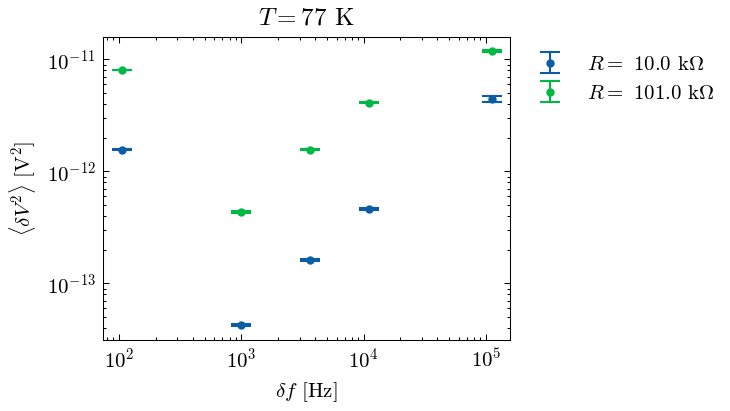

In [22]:
# over df Fluessigstickstoff
plt.figure()
plt.title(f'$T =77$ K')
dat = dat3[15:20]
y0 =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(1,3):
    dat = dat3[15+5*i:15+5*(i+1)]
    v = ua(dat['V mV'],dat[f'uV'])
    y = dv2n(v, 600, dat['g2'])
    r = dat['R Ohm'].mean()*1e-3
    plt.errorbar(dat['df kHz'],nv(y)-nv(y0),yerr=sd(y),fmt='.',label=f'$R=$ {round(r,1)} k$\Omega$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_df-77K.pdf',bbox_inches='tight')

Text(0, 0.5, '$\\langle\\delta V^2\\rangle$ [V$^2$]')

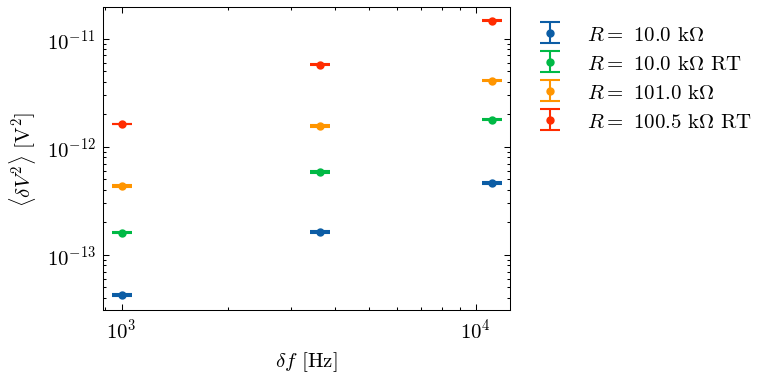

In [23]:
plt.figure()

dat = dat3[16:19]
y0_ln =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])

dat = dat3[1:4]
y0_rt =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
for i in range(1,3):
    dat_ln = dat3[16+5*i:14+5*(i+1)]
    v_ln = ua(dat_ln['V mV'],dat_ln[f'uV'])
    y_ln = dv2n(v_ln, 600, dat_ln['g2'])
    r_ln = dat_ln['R Ohm'].mean()*1e-3
    plt.errorbar(dat_ln['df kHz'],nv(y_ln)-nv(y0_ln),yerr=sd(y_ln),fmt='.',label=f'$R=$ {round(r_ln,1)} k$\Omega$')

    dat_rt = dat3[1+5*i:5*(i+1)-1]
    v_rt = ua(dat_rt['V mV'],dat_rt[f'uV'])
    y_rt = dv2n(v_rt, 600, dat_rt['g2'])
    r_rt = dat_rt['R Ohm'].mean()*1e-3
    plt.errorbar(dat_rt['df kHz'],nv(y_rt)-nv(y0_rt),yerr=sd(y_rt),fmt='.',label=f'$R=$ {round(r_rt,1)} k$\Omega$ RT')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta f$ [Hz]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
# plt.savefig(outdir+'3-johnson_rauschen_df-77K.pdf',bbox_inches='tight')

/home/emil/Documents/code/uni/FP2/venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/emil/Documents/code/uni/FP2/venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[-0.06460242388063547,
 -5.11853377265241,
 1.887843551797037,
 -0.769677306208418,
 -2.4057586837295646,
 -5.246157365050315]

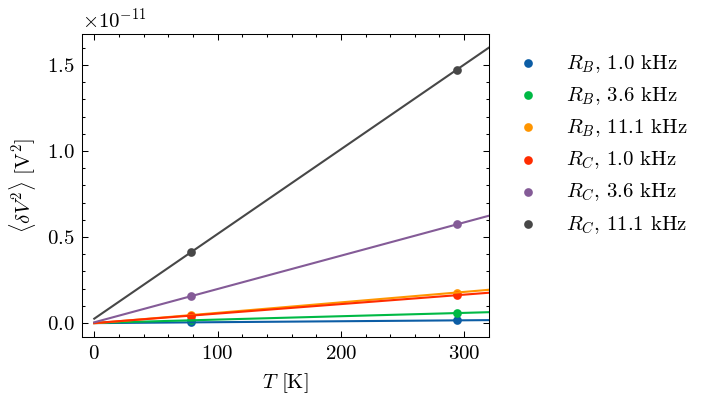

In [24]:
plt.figure()

dat = dat3[16:19]
y0_ln =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])

dat = dat3[1:4]
y0_rt =  dv2n(ua(dat['V mV'],dat[f'uV']), 600, dat['g2'])
r = ["$R_A$","$R_B$","$R_C$"]
T_0nq = []
for i in range(1,3):
    dat_ln = dat3[16+5*i:14+5*(i+1)]
    v_ln = ua(dat_ln['V mV'],dat_ln[f'uV'])
    y_ln = dv2n(v_ln, 600, dat_ln['g2'])
    r_ln = dat_ln['R Ohm'].mean()*1e-3
    # plt.errorbar(dat_ln['df kHz'],nv(y_ln)-nv(y0_ln),yerr=sd(y_ln),fmt='.',label=f'$R=$ {round(r_ln,1)} k$\Omega$')

    dat_rt = dat3[1+5*i:5*(i+1)-1]
    v_rt = ua(dat_rt['V mV'],dat_rt[f'uV'])
    y_rt = dv2n(v_rt, 600, dat_rt['g2'])
    r_rt = dat_rt['R Ohm'].mean()*1e-3
    # plt.errorbar(dat_rt['df kHz'],nv(y_rt)-nv(y0_rt),yerr=sd(y_rt),fmt='.',label=f'$R=$ {round(r_rt,1)} k$\Omega$ RT')
    for j in range(3):
        y = [nv(y_rt)[j]-nv(y0_rt)[j],nv(y_ln)[j]-nv(y0_ln)[j]]
        df = np.array(dat_ln['df kHz'])[j]*1e-3
        # print(y)
        plt.scatter(nv(temp),y,label=f'{r[i]}, {round(df,1)} kHz',s=10)
        popt, pcov  = curve_fit(linfit, nv(temp), y)

        T_0nq.append(-popt[1]/popt[0])
        tl = np.linspace(0,320,100)
        plt.plot(tl,linfit(tl, *popt))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(-10,320)
plt.xlabel('$T$ [K]')
plt.ylabel(r'$\langle\delta V^2\rangle$ [V$^2$]')
plt.savefig(outdir+'3-johnson_rauschen_T.pdf',bbox_inches='tight')
T_0nq